## Categorical Perception: A Groundwork for Deep Learning
#### Laurent Bonnasse-Gahot & Jean-Pierre Nadal
Python notebook for reproducing the results presented in Section 3.2.4, Figure 6 (Categoricality as a function of layer depth, using the MNIST dataset), panel b, as well as Figure D.2, panel b.

In [1]:
import os
import random
import numpy as np
import tensorflow as tf

# for reproducibility
SEED = 1
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

rc={'font.size': 11, 'axes.labelsize': 14, 
    'xtick.labelsize': 12, 'ytick.labelsize': 12}
sns.set(rc=rc)
sns.set_style('whitegrid', {'grid.linestyle': ':'})

In [3]:
if not os.path.exists('fig'):
    os.makedirs('fig')

In [4]:
from scipy import stats

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GaussianDropout

In [6]:
from tensorflow.keras.datasets import mnist

n_classes = 10

(x_train, y_train), (x_test, y_test) =  mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  

y_train = tf.keras.utils.to_categorical(y_train, n_classes)
y_test = tf.keras.utils.to_categorical(y_test, n_classes)

input_shape = x_train.shape[1:]

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

In [8]:
def create_model(use_dropout=True):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',
                     input_shape=input_shape, name='conv2d_1'))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', name='conv2d_2'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='max_pooling2d_1'))
    if use_dropout:
        model.add(Dropout(0.2))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', name='conv2d_3'))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', name='conv2d_4'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='max_pooling2d_2'))
    if use_dropout:
        model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', name='dense_1'))
    if use_dropout:
        model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax', name='dense_2'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])
    return model

In [9]:
def get_activation(model, x):    
    layer_outputs = [layer.output for layer in model.layers
                     if not (layer.name.startswith('dropout') 
                             or layer.name.startswith('flatten'))][:-1]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)
    return activation_model(x)

def compute_pairs(idx_per_class, n_samples_within, n_samples_between):
    n_classes = len(idx_per_class)
    is_within = np.concatenate(([True]*n_samples_within,
                                [False]*n_samples_between))
    pairs = []
    for _ in range(n_samples_within):
        i = np.random.randint(n_classes)
        pairs.append(np.random.choice(idx_per_class[i], size=2, replace=False))
    for _ in range(n_samples_between):  
        i, j = np.random.choice(n_classes, size=2, replace=False)
        pairs.append([np.random.choice(idx_per_class[i]), 
                      np.random.choice(idx_per_class[j])])
    return np.array(pairs), is_within

def cosine_distance(act1, act2):
    return (1 - np.dot(act1, act2)/(np.linalg.norm(act1)*np.linalg.norm(act2)))

def compute_distance_between_pairs(activation, pairs):
    n_layers = len(activation)
    dist_layers = []
    for i in range(n_layers):
        dist = []
        for idx1, idx2 in pairs:
            act1 = activation[i][idx1].numpy().flatten()
            act2 = activation[i][idx2].numpy().flatten()
            dist.append(cosine_distance(act1, act2))
        dist_layers.append(np.array(dist))
    return np.array(dist_layers)

def compute_categoricality(model, x_test, pairs):    
    activation_layers = get_activation(model, x_test)
    dist_layers = compute_distance_between_pairs(activation_layers, pairs)
    n_layers = len(dist_layers)
    ksstat_layers = [0 for _ in range(n_layers)]
    for idx_layer in range(n_layers):    
        dist = dist_layers[idx_layer]
        ksstat, _  = stats.ks_2samp(dist[~is_within], dist[is_within])
        ksstat_layers[idx_layer] = ksstat
    return ksstat_layers

In [10]:
idx_per_class = [np.flatnonzero(y_test[:,i]) for i in range(n_classes)]

In [11]:
n_samples_within = 1000
n_samples_between = 1000

batch_size = 128
epochs = 50

n_trials = 10

df_results = []

for trial in range(n_trials):
    print('---- computing trial #{} ----'.format(trial))
    
    pairs, is_within = compute_pairs(idx_per_class, n_samples_within, n_samples_between)
    
    model = create_model(use_dropout=True)
    layers_name = [layer.name for layer in model.layers
                   if not (layer.name.startswith('dropout') 
                           or layer.name.startswith('flatten'))][:-1]
    
    ksstat_layers_init = compute_categoricality(model, x_test, pairs)
    df_results.append(pd.DataFrame(
                {'layer':layers_name,
                 'categoricality':ksstat_layers_init,
                 'trial':trial,
                 'dropout':1,
                 'trained':0}))
    
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=0)
    ksstat_layers = compute_categoricality(model, x_test, pairs)
    df_results.append(pd.DataFrame(
            {'layer':layers_name,
             'categoricality':ksstat_layers,
             'trial':trial,
             'dropout':1,
             'trained':1}))
    
    model = create_model(use_dropout=False)
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=0)    
    ksstat_layers = compute_categoricality(model, x_test, pairs)                      
    df_results.append(pd.DataFrame(
            {'layer':layers_name,
             'categoricality':ksstat_layers,
             'trial':trial,
             'dropout':0,
             'trained':1}))

df_results = pd.concat(df_results)

---- computing trial #0 ----
---- computing trial #1 ----
---- computing trial #2 ----
---- computing trial #3 ----
---- computing trial #4 ----
---- computing trial #5 ----
---- computing trial #6 ----
---- computing trial #7 ----
---- computing trial #8 ----
---- computing trial #9 ----


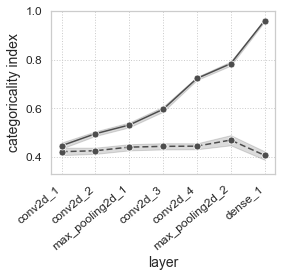

In [12]:
fh = plt.figure(figsize=(4,3))
ax = plt.subplot(111)
sns.lineplot(x='layer', y='categoricality', hue='trained', data=df_results[df_results.dropout==1], 
             palette=['0.3', '0.3'],
             style='trained',
             dashes=[(4,2), ()],
             markers=['o']*2,
             markersize=7,
             ax=ax, legend=False)
plt.xlabel('layer')
plt.ylabel('categoricality index')
plt.xticks(range(len(layers_name)), layers_name, rotation=40, ha='right')
plt.ylim((0.33, 1.0))
plt.show()
fh.savefig('fig/mnist_cnn_categoricality.pdf', bbox_inches='tight')

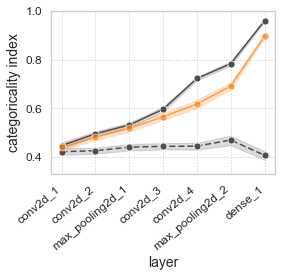

In [13]:
fh = plt.figure(figsize=(4,3))
ax = plt.subplot(111)
sns.lineplot(x='layer', y='categoricality', hue='trained', data=df_results[df_results.dropout==1], 
             palette=['0.3', '0.3'],
             style='trained',
             dashes=[(4,2), ()],
             markers=['o']*2,
             markersize=7,
             ax=ax, legend=False)
sns.lineplot(x='layer', y='categoricality', data=df_results[df_results.dropout==0],
             color='tab:orange', marker='o',        
             markersize=7,
             ax=ax, legend=False, alpha=0.7)
plt.xlabel('layer')
plt.ylabel('categoricality index')
plt.xticks(range(len(layers_name)), layers_name, rotation=40, ha='right')
plt.ylim((0.33, 1.0))
plt.show()
fh.savefig('fig/mnist_cnn_categoricality_nodropout.pdf', bbox_inches='tight')